In [1]:
import numpy as np

import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(310)
np.random.seed(310)

# Inverse Autoregressive Flow: Toy Examples

[Normalizing flows](https://arxiv.org/abs/1505.05770) denote operations that transform any simple distribution to tractable non-linear distribution.
And [inverse autoregressive flow (IAF)](https://arxiv.org/abs/1606.04934) is a class of normalizing flows.

Let's see what they really do.

## Transfrom Normal to Nonlinear Distribution

By using an IAF, we can transform 2D normal distribution to a nonlinear distribution which looks like 'x'.

In [2]:
N = int(1e4)

e = np.random.randn(N,2) # before transformation

In [3]:
def scatter(x):
    plt.scatter(x[:,0],x[:,1], s=1)

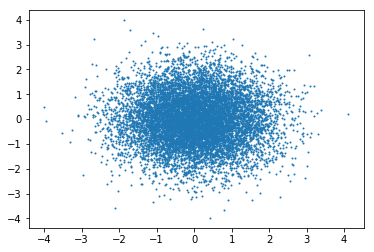

In [4]:
scatter(e)

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [6]:
def flow(x):
    "simple inverse autoregressive flow"
    x_rev = np.flip(x, 1)
    m = np.empty(x_rev.shape)
    m[:,0] = .4 * np.random.randn(N)
    m[:,1] = .8 * x_rev[:,0]
    #m[m<0] = 0 # relu
    
    s = np.empty(x_rev.shape)
    s[:,0] = 100 * np.random.randn(N)
    s[:,1] = 1/100 * x_rev[:,0]
    s = sigmoid(s)
    
    z = m + s * x_rev
    return z

In [7]:
z = flow(e)
for _ in range(10):
    z = flow(z)

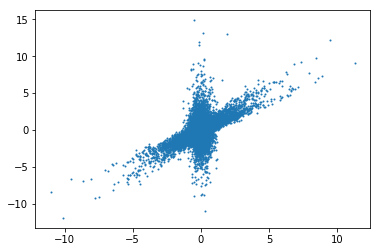

In [8]:
scatter(z)

Note that the probability density function (pdf) of this nonlinear distribution is tractable.

# Test with [Variational Auto Encoder (VAE)](https://arxiv.org/abs/1312.6114)

Let prior distribution of latent variable $z$ is standard normal distribution.
Because real distribution of z|x is intractable, we will make variational distribution z|x by using two different methods.
0. Variational distribution q(z|x) as a bivariate gaussian which is independent across axes.
0. Variational distribution q(z|x) as a bivariate IAF.

For simplification, we constrain that x follows one of four gaussians.

In [9]:
N = int(1e4)
n_class = 4
data = []
loc = [[.5,.5], [.5,.5], [.5,.5],[.5,.5]] # [[0., 0], [.0,1.], [1.,1.],[1.,.0]]
direction = [[1,1], [1,-1], [-1,-1], [-1,1]]
for i in range(n_class):
    datum = np.sqrt(np.random.rand(N//n_class, 2)) * 0.5# np.sin(.5*np.pi*np.random.rand(N//n_class, 2))*0.5
    datum = datum * direction[i] + loc[i]
    datum = Variable(torch.FloatTensor(datum))
    if torch.cuda.is_available():
        datum = datum.cuda()
    data.append(datum)
data_cat = torch.cat(data, 0)

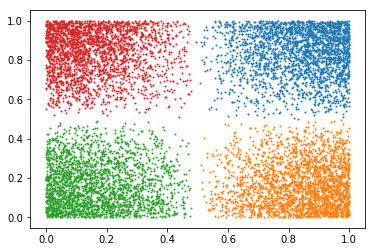

In [10]:
for i in range(n_class):
    scatter(data[i].data.cpu().numpy())

### Normal inference distribution

In [11]:
class VAE_normal(nn.Module):
    def __init__(self, n_hidden=32, n_layer=2):
        super(VAE_normal, self).__init__()
        
        self.emb_enc = nn.Linear(2, n_hidden, bias=False)
        self.lins_enc = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(n_layer)])
        self.proj_enc = nn.Linear(n_hidden, 2 * 2)
        
        self.emb_dec = nn.Linear(2, n_hidden)
        self.lins_dec = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(n_layer)])
        self.proj_dec = nn.Linear(n_hidden, 2)
        
    def forward(self, x):
        mus, sigmas = self._encode(x)
        e = Variable(torch.zeros(mus.data.size()).normal_())
        if x.is_cuda:
            e = e.cuda()
        z = mus + sigmas * e
        x_hat = self._decode(z)
        return x_hat, z, mus, sigmas
        
    def _encode(self, x):
        x = self.emb_enc(x)
        x = F.tanh(x)
        for lin in self.lins_enc:
            x = lin(x)
            x = F.tanh(x)
        
        stats = self.proj_enc(x)
        mus = stats[:,:2]
        sigmas = F.softplus(1e-6 + stats[:,2:])
        
        return mus, sigmas
    
    def _decode(self, x):
        x = self.emb_dec(x)
        x = F.tanh(x)
        for lin in self.lins_dec:
            x = lin(x)
            x = F.tanh(x)
            
        x = self.proj_dec(x)
        
        return F.sigmoid(x)
    
    def loss(self, x, x_hat, mus, sigmas):
        marginal_likelihood = torch.sum(x * torch.log(1e-8 + x_hat) + (1-x)*torch.log(1e-8 + 1-x_hat), 1)
        KL_divergence = 0.5 * torch.sum(mus**2 + sigmas**2 - 2 * torch.log(1e-8 + sigmas) - 1, 1)

        marginal_likelihood = marginal_likelihood.mean()
        KL_divergence = KL_divergence.mean()

        ELBO = marginal_likelihood - KL_divergence

        loss = -ELBO
        
        return loss, marginal_likelihood, KL_divergence

In [12]:
net_normal = VAE_normal(32, 2)
if torch.cuda.is_available():
    net_normal = net_normal.cuda()

In [13]:
optimizer = optim.Adam(net_normal.parameters(), lr=.01)

 5999: 1.38794	 -1.16524	 0.22270
0.3646


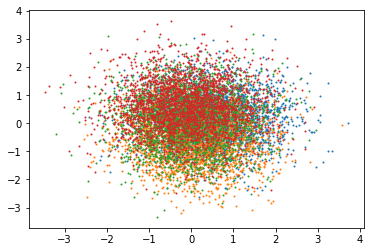

In [14]:
epochs = 6000
for i in range(epochs):
    kl_anneal_rate =  i / epochs
    
    optimizer.zero_grad()
    train_data = torch.bernoulli(data_cat)*1.
    
    x_hat, z, mus, sigmas = net_normal(train_data)
    loss, marginal_likelihood, KL_divergence = net_normal.loss(train_data, x_hat, mus, sigmas)
    (-marginal_likelihood + KL_divergence*(kl_anneal_rate)).backward() # kl_divergence annealing
    optimizer.step()
    
    print('%5d: %.5f\t %.5f\t %.5f' % (i, loss.data.cpu().numpy(), marginal_likelihood.data.cpu().numpy(), KL_divergence.data.cpu().numpy()), end='\r')
    
for i in range(n_class):
    x_hat, z, mus, sigmas = net_normal(data[i])
    scatter(z.data.cpu().numpy())
    
x_hat, *_ = net_normal(data_cat)
print()
print((np.equal(train_data.data.cpu().numpy(), np.round(x_hat.data.cpu().numpy()))).all(1).mean())

As you can see, using gaussian distributions does not gaurantee to get both performance and adequate posterior distributions.

### IAF Inference Distribution

In [15]:
def flip_h(x):
    x_size = x.data.size()
    inds = list(range(x_size[1]))[::-1]
    inds = torch.LongTensor(inds)
    if x.is_cuda:
        inds = inds.cuda()
    return x[:,inds]

In [16]:
class TrilLinear(nn.Linear):
    def __init__(self, features, bias=True):
        super(TrilLinear, self).__init__(features, features, bias)
        self.weight_tril = self.weight.tril(-1)
        
    def forward(self, input):
        weight_tril = self.weight.tril(-1)
        return F.linear(input, weight_tril, self.bias)
    
class AutoregressiveLinear(nn.Module):
    def __init__(self, autoregressive_features, context_features):
        super(AutoregressiveLinear, self).__init__()
        
        self.lin_tril = TrilLinear(autoregressive_features)
        self.lin_ctx = nn.Linear(context_features, autoregressive_features)
        
    def forward(self, input, context):
        return self.lin_tril(input) + self.lin_ctx(context)
    
class IAFLinear(nn.Module):
    def __init__(self, autoregressive_features, context_features, flip=True):
        super(IAFLinear, self).__init__()
        
        self.lin_m = AutoregressiveLinear(autoregressive_features, context_features)
        self.lin_s = AutoregressiveLinear(autoregressive_features, context_features)
        
        self.flip = flip
        
    def forward(self, x, h):
        if self.flip:
            x = flip_h(x)
        m = F.elu(self.lin_m(x, h))
        s = F.sigmoid(self.lin_s(x, h) + 2)
        z = m + s * x
        return z, m, s

In [17]:
class VAE_iaf(VAE_normal):
    def __init__(self, n_hidden=32, n_layer=2, n_layer_iaf=4):
        super(VAE_iaf, self).__init__(n_hidden, n_layer)
        
        self.proj_enc = nn.Linear(n_hidden, 2 * 3)
        
        self.lins_iaf = nn.ModuleList([IAFLinear(2, 2) for _ in range(n_layer_iaf)])
        
    def forward(self, x):
        mus, sigmas, hidden = self._encode(x)
        e = Variable(torch.zeros(mus.data.size()).normal_())
        if x.is_cuda:
            e = e.cuda()
        z = mus + sigmas * e
        z, ss = self._iaf(z, hidden)
        ss.append(sigmas)
        
        x_hat = self._decode(z)
        
        return x_hat, z, e, ss
        
    def _encode(self, x):
        x = self.emb_enc(x)
        x = F.tanh(x)
        for lin in self.lins_enc:
            x = lin(x)
            x = F.tanh(x)
        
        stats = self.proj_enc(x)
        mus = stats[:,:2]
        sigmas = F.softplus(1e-6 + stats[:,2:4])
        hidden = stats[:,4:]
        
        return mus, sigmas, hidden
    
    def _iaf(self, x, h):
        ss = []
        for lin in self.lins_iaf:
            x, m, s = lin(x, h)
            ss.append(s)
            
        return x, ss
    
    def loss(self, x, x_hat, z, e, ss):
        ss = [s.unsqueeze(-1) for s in ss]
        ss = torch.cat(ss, 2)
        
        marginal_likelihood = torch.sum(x * torch.log(1e-8 + x_hat) + (1-x)*torch.log(1e-8 + 1-x_hat), 1)
        KL_divergence = 0.5 * torch.sum(z**2 - e**2 - 2. * torch.sum(torch.log(1e-8 + ss), 2), 1)

        marginal_likelihood = marginal_likelihood.mean()
        KL_divergence = KL_divergence.mean()

        ELBO = marginal_likelihood - KL_divergence

        loss = -ELBO
        
        return loss, marginal_likelihood, KL_divergence

In [18]:
net_iaf = VAE_iaf(32, 2, 8)
if torch.cuda.is_available():
    net_iaf = net_iaf.cuda()

In [19]:
optimizer = optim.Adam(net_iaf.parameters(), lr=.01)

 5999: 1.39505	 -0.17837	 1.2166834
0.6013


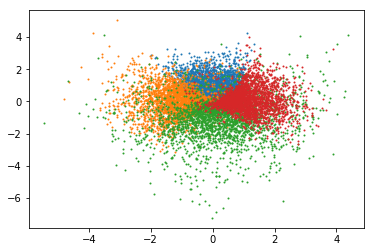

In [20]:
epochs = 6000
for i in range(epochs):
    kl_anneal_rate = i / epochs
    
    optimizer.zero_grad()
    train_data = torch.bernoulli(data_cat)*1.
    
    x_hat, z, e, ss = net_iaf(train_data)
    loss, marginal_likelihood, KL_divergence = net_iaf.loss(train_data, x_hat, z, e, ss)
    (-marginal_likelihood + KL_divergence*(kl_anneal_rate)).backward() # kl_divergence annealing
    optimizer.step()
    
    print('%5d: %.5f\t %.5f\t %.5f' % (i, loss.data.cpu().numpy(), marginal_likelihood.data.cpu().numpy(), KL_divergence.data.cpu().numpy()), end='\r')
    
for i in range(n_class):
    x_hat, z, e, ss = net_iaf(data[i])
    scatter(z.data.cpu().numpy())
    
x_hat, *_ = net_iaf(data_cat)
print()
print((np.equal(train_data.data.cpu().numpy(), np.round(x_hat.data.cpu().numpy()))).all(1).mean())

By using IAF, we can get better result than with naive gaussians at every espect.